# Imports & data!

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
import GPyOpt
import random
from IPython.display import clear_output
import time

In [2]:
# set seeds 
seed=42
random.seed(seed)  # Python
np.random.seed(seed)  # NumPy
torch.manual_seed(seed)  # PyTorch
torch.cuda.manual_seed_all(seed)  # PyTorch CUDA

In [3]:
# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the full CIFAR10 datasets
data_dir = './CIFAR10_data'
full_dataset = datasets.CIFAR10(data_dir, download=True, train=True, transform=transform)

# Define the size of the subset for training and validation
total_subset_size = 3200  # Total subset size
train_subset_size = int(0.8 * total_subset_size)  # 80% of the total subset size
val_subset_size = total_subset_size - train_subset_size  # 20% of the total subset size

# Create indices for the subset
indices = list(range(len(full_dataset)))
np.random.shuffle(indices)

train_indices = indices[:train_subset_size]
val_indices = indices[train_subset_size:train_subset_size + val_subset_size]  # Validation set is a subset of the training data

# Create subset datasets
trainset = Subset(full_dataset, indices=train_indices)
valset = Subset(full_dataset, indices=val_indices)

# Create DataLoaders from the subset datasets with batch size
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
val_loader = DataLoader(valset, batch_size=32, shuffle=False)  # No need to skip batches with smaller size

Files already downloaded and verified


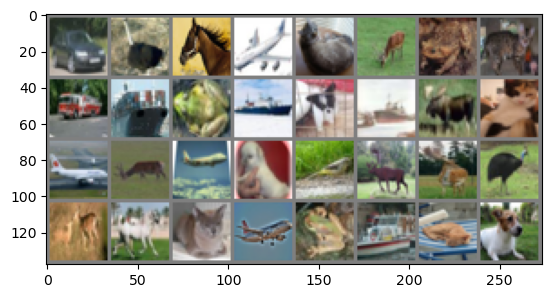

In [4]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

# example showcase
def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # convert from Tensor image
    plt.show()

imshow(torchvision.utils.make_grid(images))

# Model architecture!

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, num_classes, num_neurons, kernel_size):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=kernel_size, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, padding=1)
        # Placeholder for the dynamic size calculation
        self.num_neurons = num_neurons
        self.num_classes = num_classes
        self.kernel_size = kernel_size

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Dynamically calculate the size based on the tensor dimensions
        num_features = x.size(1) * x.size(2) * x.size(3)
        if not hasattr(self, 'fc1'):
            # Initialize FC layers here to use dynamic size
            self.fc1 = nn.Linear(num_features, self.num_neurons)
            self.fc2 = nn.Linear(self.num_neurons, self.num_classes)
            self.fc1 = self.fc1.to(x.device)
            self.fc2 = self.fc2.to(x.device)
        
        #print(f"Size before view: {x.size()}")  # For debugging
        x = x.view(-1, num_features)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training structure!

In [6]:
def train_and_evaluate_model(model, trainloader, val_loader, lr, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    best_val_acc = 0.0
    best_train_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]'):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            train_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(preds == labels.data)

        # Calculate training loss and accuracy for the epoch
        train_epoch_loss = train_loss / len(trainloader.dataset)
        train_epoch_acc = train_corrects.double() / len(trainloader.dataset)

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_corrects.double() / len(val_loader.dataset)
        
        print(f'Training Loss: {train_epoch_loss:.4f} Acc: {train_epoch_acc:.4f}')
        print(f'Validation Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')

        # Update best validation accuracy if current epoch's accuracy is higher
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
        
        if train_epoch_acc > best_train_acc:
            best_train_acc = train_epoch_acc
    
    clear_output(wait=True)
    #print(f'Best Training Accuracy: {train_epoch_acc:.4f}')
    #print(f'Best Validation Accuracy: {best_val_acc:.4f}')

    return best_val_acc.cpu().numpy()

# Grid search!

In [7]:
# domain of the hyperparameters
domain = [{'name': 'num_neurons', 'type': 'discrete', 'domain': (1, 1024)},
          {'name': 'lr', 'type': 'continuous', 'domain': (1e-6, 1e-1)}]

#train 
num_epochs = 4

#grid definition
num_neurons_bins = 32
lr_bins = 32

In [8]:
counter = 0

def objective(x):
    global counter
    counter += 1
    print(f"Iteration {counter}")
    num_neurons = int(x[0, 0])
    lr = x[0, 1]
    #kernel_size = int(x[0, 1])
    
    # Instantiate model
    model_instance = SimpleCNN(in_channels=3, num_classes=10, num_neurons=num_neurons, kernel_size=3) #kernel_size=kernel_size)
    
    # model instance to training and evaluation
    evaluation = train_and_evaluate_model(model_instance, trainloader, val_loader, lr, num_epochs)
    return evaluation

In [9]:
def plot_heatmap(results, num_neurons_edges, lr_edges, best_params):
    plt.figure(figsize=(10, 8))
    # Display the results as a heatmap
    plt.imshow(results, aspect='auto', origin='lower',
               extent=[lr_edges[0], lr_edges[-1], num_neurons_edges[0], num_neurons_edges[-1]],  # Adjust the y-axis extent
               interpolation='nearest', cmap='viridis')
    plt.colorbar(label='Validation Accuracy Value')  # Corrected label
    plt.xlabel('Learning Rate (lr)')
    plt.ylabel('Number of Neurons (num_neurons)')
    plt.title('Grid Search Heatmap')  # Corrected title

    # Add a red dot at the location of the best accuracy
    best_lr = best_params['lr']
    best_num_neurons = best_params['num_neurons']
    plt.plot(best_lr, best_num_neurons, 'ro')

    # Add red lines connecting the dot to the axes
    plt.axvline(x=best_lr, color='r', linestyle='--')
    plt.axhline(y=best_num_neurons, color='r', linestyle='--')

    # Specify the locations of the x and y axis labels
    plt.xticks(np.linspace(lr_edges[0], lr_edges[-1], num=10))  # 10 labels along the x axis
    plt.yticks(np.linspace(num_neurons_edges[0], num_neurons_edges[-1], num=10))  # 10 labels along the y axis
    
    plt.show()

In [10]:
def grid_search_objective(objective, domain, num_neurons_bins, lr_bins):
    # Define the range for num_neurons and lr
    num_neurons_range = np.linspace(domain[0]['domain'][0], domain[0]['domain'][1], num_neurons_bins)
    lr_range = np.linspace(domain[1]['domain'][0], domain[1]['domain'][1], lr_bins)

    # initialize the results matrix for validation accuracies
    val_acc_results = np.zeros((num_neurons_bins, lr_bins))

    # track best parameters
    best_val_acc = 0.0
    best_params = None

    # iterate over each combination of num_neurons and lr
    for i, num_neurons in enumerate(num_neurons_range):
        for j, lr in enumerate(lr_range):
            x_sample = np.array([[num_neurons, lr]])

            val_acc = objective(x_sample)

            val_acc_results[i, j] = val_acc

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = {'num_neurons': num_neurons, 'lr': lr}

    # the edges are just the ranges used for num_neurons and lr
    num_neurons_edges = np.append(num_neurons_range, num_neurons_range[-1] + (num_neurons_range[1] - num_neurons_range[0]))
    lr_edges = np.append(lr_range, lr_range[-1] + (lr_range[1] - lr_range[0]))

    return val_acc_results, num_neurons_edges, lr_edges, best_params, best_val_acc

In [11]:
val_acc_results, num_neurons_edges, lr_edges, best_params, best_val_acc = grid_search_objective(objective, domain, num_neurons_bins, lr_bins)

Iteration 100


Epoch 1/4 [Training]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 1/4 [Validation]:   0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 2.3101 Acc: 0.1613
Validation Loss: 2.2210 Acc: 0.1594


Epoch 2/4 [Training]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 2/4 [Validation]:   0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 2.1434 Acc: 0.2203
Validation Loss: 2.1215 Acc: 0.2188


Epoch 3/4 [Training]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 3/4 [Validation]:   0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 2.1304 Acc: 0.2313
Validation Loss: 2.0814 Acc: 0.2234


Epoch 4/4 [Training]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 4/4 [Validation]:   0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 2.0525 Acc: 0.2543
Validation Loss: 2.1139 Acc: 0.2313


In [12]:
print(f"Best parameters found (Grid Search): {best_params}")
print(f"Best validation accuracy found (Grid Search): {best_val_acc}")

Best parameters found (Grid Search): {'num_neurons': 569.3333333333334, 'lr': 0.011112}
Best validation accuracy found (Grid Search): 0.375


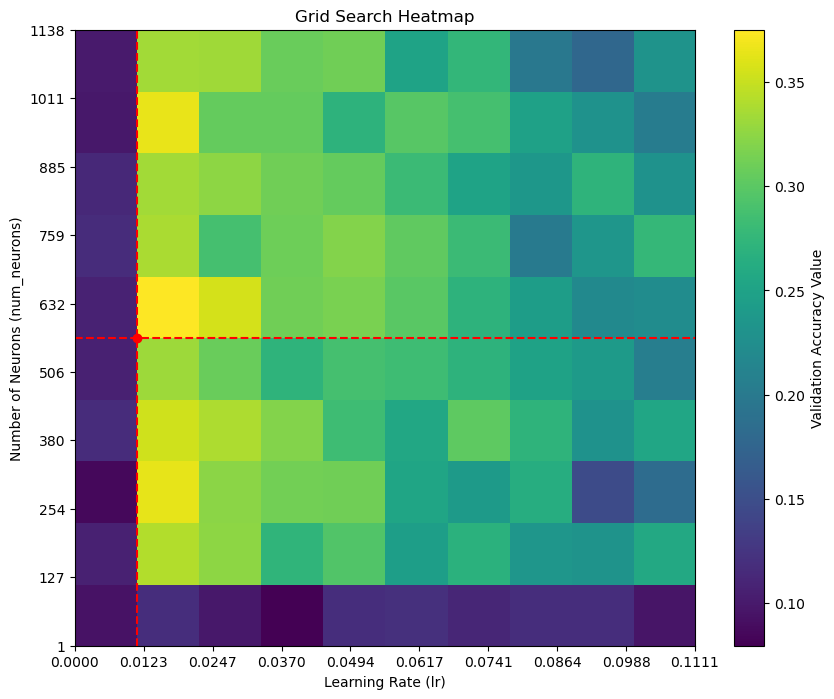

In [13]:
plot_heatmap(val_acc_results, num_neurons_edges, lr_edges, best_params)

# Bayesian optimization!

In [14]:
# accuracy to beat/find
print(f"Best validation accuracy found (Grid Search): {best_val_acc:.4f}%")

Best validation accuracy found (Grid Search): 0.3750%


In [26]:
counter = 0

def objective(x):
    global counter
    counter += 1
    print(f"Iteration {counter}")
    num_neurons = int(x[0, 0])
    lr = x[0, 1]
    
    # Instantiate and evaluate the model
    model_instance = SimpleCNN(in_channels=3, num_classes=10, num_neurons=num_neurons, kernel_size=3)
    validation_accuracy = train_and_evaluate_model(model_instance, trainloader, val_loader, lr, num_epochs) 
    
    return -validation_accuracy  # Minimize negative accuracy (i.e., maximize accuracy)

In [27]:
iteration = 0
max_iterations = 2500  # Set a maximum to prevent infinite loops

# gpyopt
opt = GPyOpt.methods.BayesianOptimization(f=objective, domain=domain, acquisition_type ='EI')
opt.acquisition.exploration_weight = 0.5

current_best = 0
best_val_acc_bo = 0  # worst possible accuracy

# store the results
bo_results = []

while iteration < max_iterations:
    print(f"Best validation so far: {current_best:.4f}")

    opt.run_optimization(max_iter=1)  # run a single iteration at a time
    current_best = -opt.fx_opt  # fx_opt is the best found value, negate it to get accuracy back
        
    if current_best > best_val_acc_bo:
        best_val_acc_bo = current_best
        
    if best_val_acc_bo >= best_val_acc:  
        print("BO has matched or exceeded the target validation accuracy.")
        break
    
    # store the hyperparameters and validation accuracy
    best_params_bo = opt.x_opt
    bo_results.append((best_params_bo[0], best_params_bo[1], current_best))
    
    iteration += 1
    
    clear_output(wait=True)

best_params_bo = opt.x_opt
print(f"Best parameters found (Bayesian optimization): Num_neurons={best_params_bo[0]}, lr={best_params_bo[1]}")
print(f"Best validation accuracy found (Bayesian optimization): {best_val_acc_bo:.4f}")
print(f"Total iterations: {iteration}")

Best validation so far: 0.3656
Iteration 45


Epoch 1/4 [Training]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 1/4 [Validation]:   0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 2.1438 Acc: 0.2168
Validation Loss: 2.0103 Acc: 0.2750


Epoch 2/4 [Training]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 2/4 [Validation]:   0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 1.9282 Acc: 0.3012
Validation Loss: 1.9382 Acc: 0.3016


Epoch 3/4 [Training]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 3/4 [Validation]:   0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 1.8218 Acc: 0.3445
Validation Loss: 1.8800 Acc: 0.3484


Epoch 4/4 [Training]:   0%|          | 0/80 [00:00<?, ?it/s]

KeyboardInterrupt: 

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

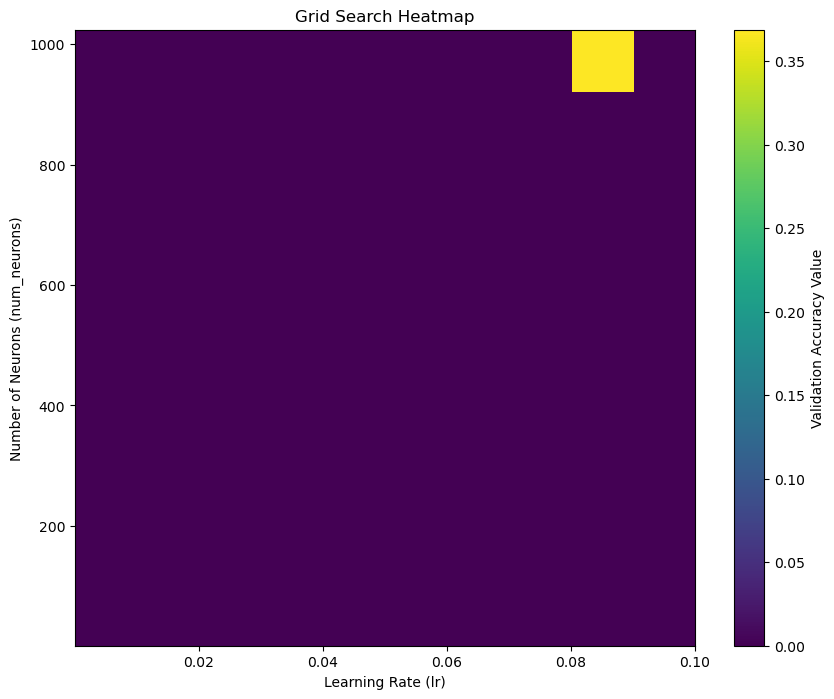

In [25]:
# convert bo_results to a numpy array
bo_results_array = np.array(bo_results)

# define the edges for the plot
bo_num_neurons_edges = np.linspace(1, 1024, num_neurons_bins + 1)
bo_lr_edges = np.logspace(np.log10(1e-6), np.log10(1e-1), lr_bins + 1)

# create a 2D histogram for the Bayesian Optimization results
bo_hist, _, _ = np.histogram2d(bo_results_array[:, 0], bo_results_array[:, 1], bins=[bo_num_neurons_edges, bo_lr_edges], weights=bo_results_array[:, 2])

# create a dictionary from best_params_bo
best_params_dict = {'num_neurons': best_params_bo[0], 'lr': best_params_bo[1]}

# plot the heatmap
plot_heatmap(bo_hist, bo_num_neurons_edges, bo_lr_edges, best_params_dict)

In [ ]:
for result in bo_results:
    print(f"Num_neurons={result[0]}, lr={result[1]}, val_acc={result[2]}")

Num_neurons=64.0, lr=0.007900081965098447, val_acc=0.42828125
Num_neurons=64.0, lr=0.007900081965098447, val_acc=0.42828125
Num_neurons=64.0, lr=0.007900081965098447, val_acc=0.42828125
Num_neurons=64.0, lr=0.007900081965098447, val_acc=0.42828125
Num_neurons=64.0, lr=0.007900081965098447, val_acc=0.42828125
Num_neurons=64.0, lr=0.007900081965098447, val_acc=0.42828125
Num_neurons=64.0, lr=0.007900081965098447, val_acc=0.42828125
Num_neurons=64.0, lr=0.007900081965098447, val_acc=0.42828125
Num_neurons=64.0, lr=0.007900081965098447, val_acc=0.42828125
Num_neurons=64.0, lr=0.007900081965098447, val_acc=0.42828125
Num_neurons=64.0, lr=0.007900081965098447, val_acc=0.42828125
Num_neurons=64.0, lr=0.007900081965098447, val_acc=0.42828125
Num_neurons=64.0, lr=0.007900081965098447, val_acc=0.42828125
Num_neurons=64.0, lr=0.007900081965098447, val_acc=0.42828125
Num_neurons=64.0, lr=0.007900081965098447, val_acc=0.42828125
Num_neurons=64.0, lr=0.007900081965098447, val_acc=0.42828125
Num_neur